# 05 Decision Algorithm to simulate Buy/Sell

In [434]:
import plot_helper as ph
from pandas.tseries.offsets import DateOffset
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [8]:
import data_prep_helper
do_big = data_prep_helper.ModelData(chart_col=["Price", "High", "Low", "Price_norm"])


Using TensorFlow backend.


In [18]:
dates = do_big.get_forecast_dates()

In [268]:

growth_list = []
for curr_day in dates[30:]:
    day_dict = {}
    ari_forecast = do_big.ari_forecast(curr_day, shift=-31)
    ari_df = ari_forecast.predicted_mean
    ari_df.index = ari_df.index + DateOffset(31)
    
    gru_df = do_big.gru_forecast(curr_day, shift=-31)
    real_price, real_30 = do_big.get_real_price(curr_day, shift=-31)
    
    curr_date = datetime.strptime(curr_day, "%Y-%m-%d")
    future_offset = curr_date + DateOffset(31)
    
    past_offset = curr_date + DateOffset(-10)

    
    ari_future = ari_df[(ari_df.index < future_offset) & (ari_df.index >= curr_date)].iloc[-25:].rolling(window=5, min_periods=1).mean()
    ari_growth = np.round(100 - ((ari_future[0]/ari_future[-1])*100),2)
    day_dict["ari_growth"] = ari_growth
    gru_future = gru_df[(gru_df.index < future_offset) & (gru_df.index >= curr_date)].iloc[-25:].rolling(window=5, min_periods=1).mean()
    gru_growth = np.round(100 - ((gru_future.values[0]/gru_future.values[-1])*100),2)[0]
    day_dict["gru_growth"] = gru_growth
    #real_future = real_30.iloc[-15:,:].rolling(window=5, min_periods=1).mean()
    #real_growth = np.round(100 - ((real_future.values[0]/real_future.values[-1])*100),2)[0]
    #day_dict["real_growth"] = real_growth
    
    real_past = real_price[real_price.index > past_offset].rolling(window=5, min_periods=1).mean()
    real_past = np.round(100 - ((real_past.values[0]/real_past.values[-1])*100),2)[0]
    day_dict["real_past"] = real_past

    growth_list.append(day_dict)


In [269]:
growth_dict = pd.DataFrame(growth_list, index=ari_df.index[30:-30])

In [270]:
growth_dict["comb_pred"] = (growth_dict["ari_growth"] + growth_dict["gru_growth"]) / 2

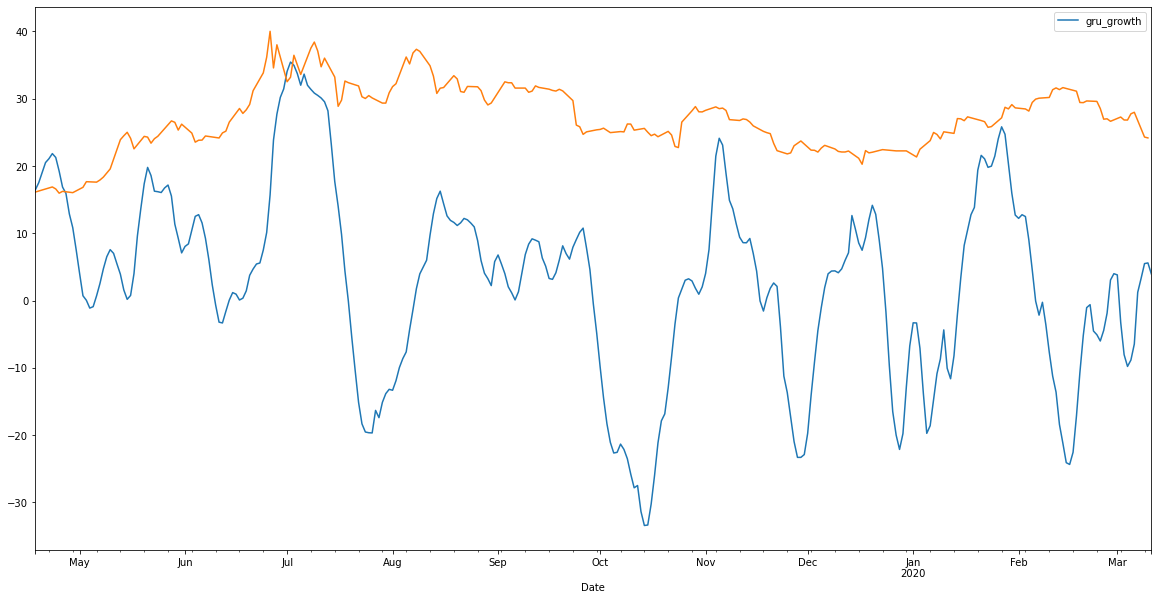

In [279]:
growth_dict[["gru_growth"]].plot(figsize=(20,10))
(((real_price["bitcoin_Price"].iloc[30:]*10)/real_price["bitcoin_Price"].iloc[30:].max())*4).plot()

In [263]:
from scipy.signal import argrelextrema

In [229]:
gru_gro = growth_dict[["gru_growth"]]

In [230]:
gru_gro.head()

,gru_growth
2019-04-18,15.77
2019-04-19,15.99
2019-04-20,17.32
2019-04-21,19.14
2019-04-22,20.77


In [430]:
n=1 # number of points to be checked before and after 
# Find local peaks

min_val = argrelextrema(gru_gro.gru_growth.values, np.less_equal, order=n)[0]
max_val = argrelextrema(gru_gro.gru_growth.values, np.greater_equal, order=n)[0]

min_val = [x+n for x in min_val]
max_val = [x+n for x in max_val]


gru_gro['min'] = gru_gro.iloc[min_val[:-1]]['gru_growth']
gru_gro['max'] = gru_gro.iloc[max_val[:-1]]['gru_growth']



In [432]:
#gru_gro['min'][gru_gro['min'] > 0] = np.nan
gru_gro['max'][gru_gro['max'] < 0] = np.nan


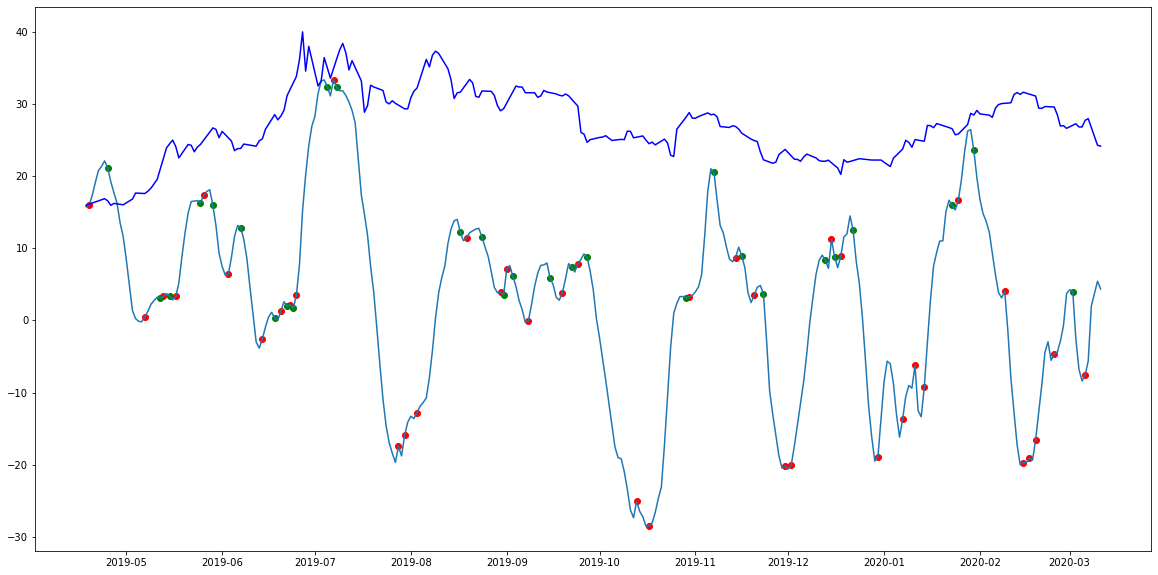

In [435]:
# Plot results

fig = plt.figure(figsize=(20,10))

plt.scatter(gru_gro.index, gru_gro['min'], c='r')
plt.scatter(gru_gro.index, gru_gro['max'], c='g')
plt.plot(gru_gro.index, gru_gro['gru_growth'])
plt.plot(gru_gro.index,((real_price["bitcoin_Price"].iloc[29:]*10)/real_price["bitcoin_Price"].iloc[29:].max())*4, c='b')
plt.plot(figsize=(20,10))
plt.show()

In [460]:
budget = 100000
init_val = budget
last_sell_val = budget
last_sell_max = np.nan
last_buy_min = np.nan
bitcoin = 0
min_mem = []
max_mem = []
start=0


last_status = "sell"

for curr_day in dates[31:]:
    curr_price = float(real_price[real_price.index == curr_day]["bitcoin_Price"])
    
    ### BUYING
    min_val = float(gru_gro[gru_gro.index == curr_day]["min"].values)
    if np.isfinite(min_val) and (last_status == "sell"):
        last_buy_min = min_val
        dist = abs(abs(last_buy_min)-abs(last_sell_max))
        if (dist>3) or (start==0):
            print("BUY_DISTANCE: {}".format(dist))
            start=1
            bitcoin = budget/curr_price
            budget = 0
            last_status = "buy"

            print("{}: Buy Bitcoin for {}\n\tNow having {} Bitcoin\n".format(curr_day, curr_price, bitcoin))

    ### SELLING
    max_val = float(gru_gro[gru_gro.index == curr_day]["max"].values)
    if np.isfinite(max_val) and (last_status == "buy"):
        last_sell_max = max_val
        dist = abs(abs(last_buy_min)-abs(last_sell_max))
        if (dist>3):
            print("SELL_DISTANCE: {}".format(dist))
            budget = bitcoin*curr_price
            bitcoin = 0
            last_status = "sell"
            if budget < last_sell_val:
                result_marker = "[-]"
            else:
                result_marker = "[+]"
            last_sell_val = budget
            print("{} {}: Sell Bitcoin for {}\n\tNow having {} Dollar\n".format(result_marker ,curr_day, curr_price, budget))



BUY_DISTANCE: nan
2019-04-19: Buy Bitcoin for 5314.08
	Now having 18.817932737181224 Bitcoin

SELL_DISTANCE: 5.17
[-] 2019-04-25: Sell Bitcoin for 5209.1
	Now having 98024.49342125072 Dollar

BUY_DISTANCE: 20.65
2019-05-07: Buy Bitcoin for 5849.5
	Now having 16.757755948585473 Bitcoin

SELL_DISTANCE: 15.78
[+] 2019-05-25: Sell Bitcoin for 8156.65
	Now having 136687.15005802969 Dollar

BUY_DISTANCE: 9.87
2019-06-03: Buy Bitcoin for 8124.8
	Now having 16.82344796893827 Bitcoin

SELL_DISTANCE: 6.43
[-] 2019-06-07: Sell Bitcoin for 7985.2
	Now having 134338.59672156587 Dollar

BUY_DISTANCE: 10.29
2019-06-14: Buy Bitcoin for 8656.1
	Now having 15.51952920155334 Bitcoin

SELL_DISTANCE: 29.860000000000003
[+] 2019-07-05: Sell Bitcoin for 10970.2
	Now having 170252.33924688047 Dollar

BUY_DISTANCE: 14.940000000000001
2019-07-28: Buy Bitcoin for 9664.266666666666
	Now having 17.61668475416798 Bitcoin

SELL_DISTANCE: 5.26
[+] 2019-08-17: Sell Bitcoin for 10527.300000000001
	Now having 185456.125

In [594]:
budget = 100000
dist_val = 5
n = 1
future_offset_val=31
gru_window=12

bitcoin = 0
last_bitcoin_price=0

# initial baseline for selling profit
last_sell_val = budget

# init of n-1 iterations minima and maxima 
last_sell_max = np.nan
last_buy_min = np.nan

# init length of found minima/maxima
min_val_arr_last = 0
max_val_arr_last = 0

# start condition for first iteration
start=0
last_status = "sell"

# init lists for results
grow_vals = []
result_list = []

for curr_day in do_big.get_forecast_dates()[5:]:
    result_dict = {}
    # convert date string to datetime
    curr_date = datetime.strptime(curr_day, "%Y-%m-%d")
    result_dict["date"] = curr_date

    # apply offset for extracting forecast timespan
    future_offset = curr_date + DateOffset(future_offset_val)

    # get current real_price
    real_price, _ = do_big.get_real_price(curr_day)
    curr_price = float(real_price[real_price.index == curr_day]["bitcoin_Price"])
    result_dict["curr_price"] = curr_price

    # get GRU model based prediction with maximum of 26 days future forecast
    gru_df = do_big.gru_forecast(curr_day, shift=-31)
    lookback_offset = 6


    gru_ext_win = (future_offset_val-lookback_offset)*-1
    gru_future = gru_df[(gru_df.index < future_offset) & (gru_df.index >= curr_date)].iloc[gru_ext_win:].rolling(window=gru_window, min_periods=1).mean()
    # calculate growth for future forecast
    gru_growth = np.round(100 - ((gru_future.values[0]/gru_future.values[-1])*100),2)[0]
    grow_vals.append(gru_growth)
    result_dict["gru_growth"] = gru_growth

    # calculate local minima's from GRU growth plot
    min_val_arr = argrelextrema(np.array(grow_vals), np.less_equal, order=n)[0]
    min_val_arr_len = len(min_val_arr)

    # calculate local maxima's from GRU growth plot
    max_val_arr = argrelextrema(np.array(grow_vals), np.greater, order=n)[0]
    max_val_arr_len = len(max_val_arr)

    # init min and max values that are trigger for buy(min) and sell(max)
    min_val = np.nan
    max_val = np.nan

    # if a new minima was found, a min_val will be set
    if (min_val_arr_len > min_val_arr_last):
        min_val = grow_vals[min_val_arr[-1]]
        min_val_arr_last = min_val_arr_len

    # if a new maxima was found, a max_val will be set
    if (max_val_arr_len > max_val_arr_last):
        max_val = grow_vals[max_val_arr[-1]]
        max_val_arr_last = max_val_arr_last

    # Remove all local maxima that are below Zero
    # because this would lead to many wrong selling decisions
    if (max_val < 0):
        max_val = np.nan

    # buying logic: if min_val is set and last action was a sell we will go further
    if np.isfinite(min_val) and (last_status == "sell"):
        # store minimum value for next iteration for calculating distance
        last_buy_min = min_val
        dist = abs(abs(last_buy_min)-abs(last_sell_max))
        # a specific absolute distance has to be between previous maxima current minima
        # or start for first step without dist set
        if (dist>dist_val) or (start==0):
            # the new minimum has to be smaller than last maximum for
            # preventing many wrong buying decisions
            if (min_val < last_sell_max) or (start==0):
                result_dict["buy_trigger"] = min_val
                result_dict["buy_price"] = curr_price

                # negate first iteration condition
                start=1

                # buy bitcoin
                bitcoin = budget/curr_price
                budget = 0
                last_status = "buy"

                print("{}: Buy Bitcoin for {}\n\tNow having {} Bitcoin\n".format(curr_day, curr_price, bitcoin))

    # selling logic: if max_val is set and last action was a buy we will go further
    if np.isfinite(max_val) and (last_status == "buy"):
        # store maximum value for next iteration for calculating distance
        last_sell_max = max_val
        dist = abs(abs(last_buy_min)-abs(last_sell_max))
        # a specific absolute distance has to be between previous minima current minima
        if (dist>dist_val):
            result_dict["sell_trigger"] = max_val
            result_dict["sell_price"] = curr_price

            # sell bitcoin
            budget = bitcoin*curr_price
            bitcoin = 0
            last_status = "sell"

            # store 1 if last sell was profitable and 0 if not
            if budget < last_sell_val:
                result_dict["profit"] = 0
            else:
                result_dict["profit"] = 1
            last_sell_val = budget
            print("{} {}: Sell Bitcoin for {}\n\tNow having {} Dollar\n".format(result_marker ,curr_day, curr_price, budget))

    result_dict["budget"] = budget
    result_dict["bitcoin"] = bitcoin

    result_list.append(result_dict)

2019-03-23: Buy Bitcoin for 3972.6
	Now having 25.172431153400797 Bitcoin

[-] 2019-04-23: Sell Bitcoin for 5511.6
	Now having 138740.37154508385 Dollar

2019-05-10: Buy Bitcoin for 6386.0
	Now having 21.725708040257416 Bitcoin

[-] 2019-05-21: Sell Bitcoin for 7930.3
	Now having 172291.3824716534 Dollar

2019-06-16: Buy Bitcoin for 9097.9
	Now having 18.937489142731113 Bitcoin

[-] 2019-07-03: Sell Bitcoin for 11900.8
	Now having 225371.2707898144 Dollar

2019-07-27: Buy Bitcoin for 9747.633333333333
	Now having 23.120614315592615 Bitcoin

[-] 2019-08-22: Sell Bitcoin for 10105.0
	Now having 233633.80765906337 Dollar

2019-08-29: Buy Bitcoin for 9491.0
	Now having 24.61635314077161 Bitcoin

[-] 2019-09-01: Sell Bitcoin for 10098.849999999999
	Now having 248596.85791568135 Dollar

2019-10-12: Buy Bitcoin for 8296.3
	Now having 29.964786460914066 Bitcoin

[-] 2019-10-28: Sell Bitcoin for 9207.2
	Now having 275891.781902928 Dollar

2020-01-10: Buy Bitcoin for 8187.1
	Now having 33.698352

Wow, it seems we got actually a really good triggering for Buys and Sells of Bitcoin. Actually we can toggle our parameters a bit and it becomes sometimes a bit less but it's really difficult with this algorithm to end with less money than in the beginning of the simulation.

Now it should be tested on more recent data, that means I have to wait a bit and will test it again. At the end I will plot the buy and sell triggers with the GRU growth plot against the real price chart:

In [595]:
sim_result = pd.DataFrame(result_list).set_index("date")

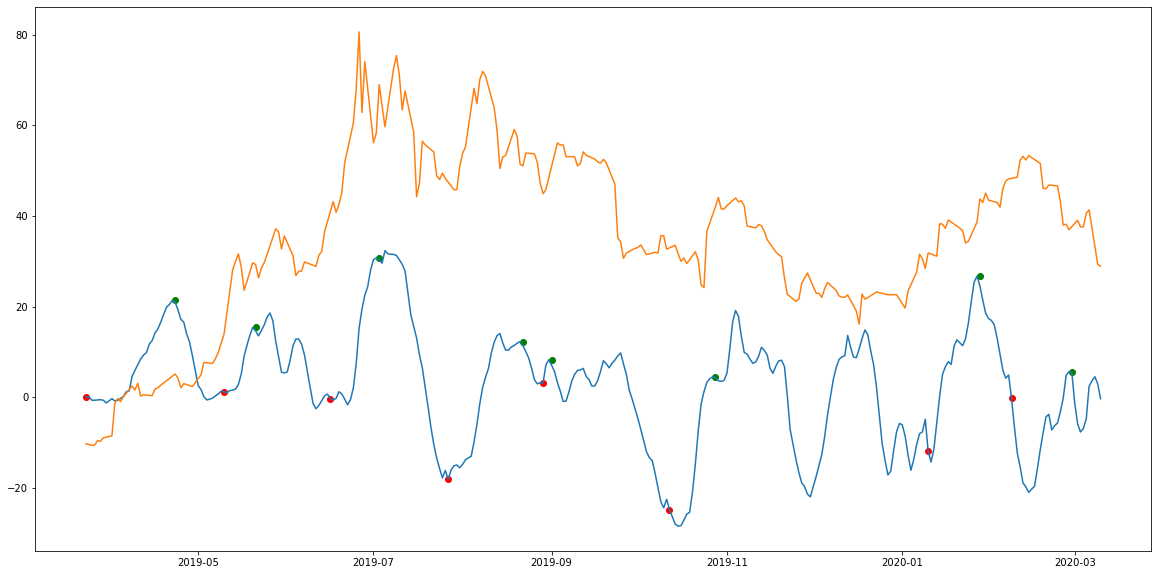

In [596]:
fig = plt.figure(figsize=(20,10))


plt.scatter(sim_result.index,sim_result["buy_trigger"], c="r")
plt.scatter(sim_result.index,sim_result["sell_trigger"], c="g")
plt.plot(sim_result.index, sim_result["gru_growth"])
plt.plot(sim_result.index, ((sim_result["curr_price"]*10)/1000)-50)